In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\presh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\presh\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\presh\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\presh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
df = pd.read_csv('Reviews.csv')

In [3]:
df.shape

(568454, 10)

In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


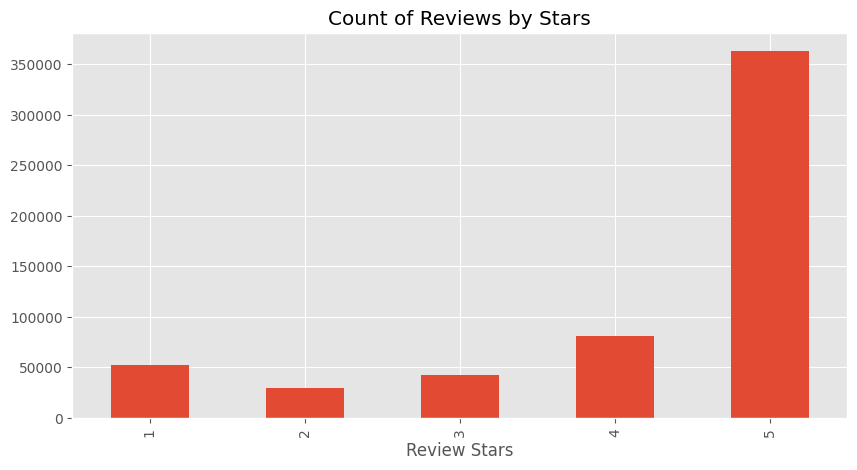

In [5]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [6]:
example = df['Text'][2000]
example

'I usually make pancakes from scratch and have never found a mix that doesn\'t taste "off" to me.  This mix is the best!!!  My family and I love the way it tastes and it is so quick and easy.'

In [7]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['I',
 'usually',
 'make',
 'pancakes',
 'from',
 'scratch',
 'and',
 'have',
 'never',
 'found']

In [8]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('I', 'PRP'),
 ('usually', 'RB'),
 ('make', 'VBP'),
 ('pancakes', 'NNS'),
 ('from', 'IN'),
 ('scratch', 'NN'),
 ('and', 'CC'),
 ('have', 'VBP'),
 ('never', 'RB'),
 ('found', 'VBN')]

In [9]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  I/PRP
  usually/RB
  make/VBP
  pancakes/NNS
  from/IN
  scratch/NN
  and/CC
  have/VBP
  never/RB
  found/VBN
  a/DT
  mix/NN
  that/WDT
  does/VBZ
  n't/RB
  taste/VB
  ``/``
  off/RB
  ''/''
  to/TO
  me/PRP
  ./.
  This/DT
  mix/NN
  is/VBZ
  the/DT
  best/JJS
  !/.
  !/.
  !/.
  My/PRP$
  family/NN
  and/CC
  I/PRP
  love/VBP
  the/DT
  way/NN
  it/PRP
  tastes/VBZ
  and/CC
  it/PRP
  is/VBZ
  so/RB
  quick/JJ
  and/CC
  easy/JJ
  ./.)


In [ ]:
# VADER Sentiment Scoring

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
sia = SentimentIntensityAnalyzer()

In [11]:
sia.polarity_scores('I am very very happy!')

{'neg': 0.0, 'neu': 0.397, 'pos': 0.603, 'compound': 0.6771}

In [12]:
sia.polarity_scores('This is worst case. I do not like it')

{'neg': 0.509, 'neu': 0.491, 'pos': 0.0, 'compound': -0.7359}

In [13]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.726, 'pos': 0.274, 'compound': 0.9252}

In [14]:
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)


  0%|          | 0/568454 [00:00<?, ?it/s]

In [15]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [17]:
vaders.head(3)

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


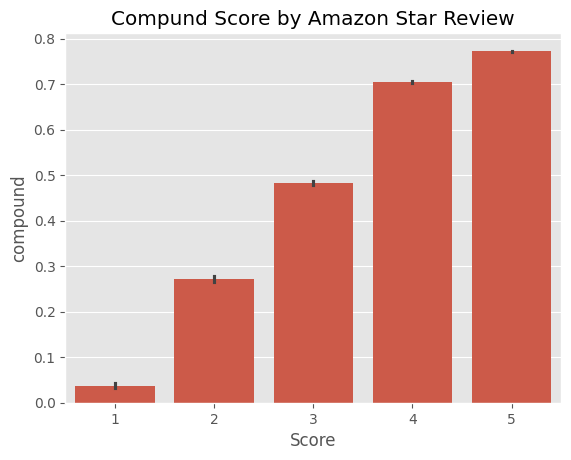

In [18]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

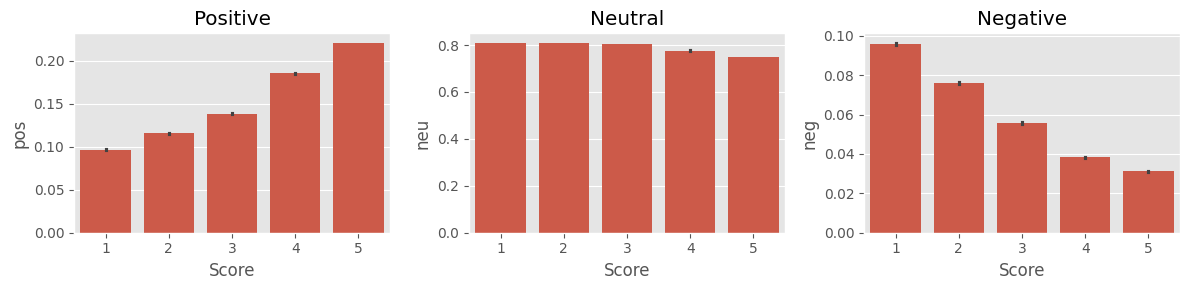

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()